In [5]:
import zipfile

def unzip_file(zip_file_path, extract_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

# Example usage:
zip_file_path = 'train_images_zip/train_image2.zip'
extract_folder = 'train_images'

unzip_file(zip_file_path, extract_folder)


In [ ]:
def unzip_file(zip_file_path, extract_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

# Example usage:
zip_file_path_test = 'train_images_zip/train_image2.zip'
extract_folder_test = 'train_images'

unzip_file(zip_file_path_test, extract_folder_test)

In [2]:
pip install opencv-python tqdm

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/b7/8a/b2f7e1a434d56bf1d7570fc5941ace0847404e1032d7f1f0b8fed896568d/opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 44.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 37.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model

import os
# from google.colab import drive
# drive.mount('/content/drive')
import glob
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [10]:
len(os.listdir('dataset/dataset_'))

1459

In [16]:
1459*0.2

291.8

In [17]:
1459 - 292

1167

In [4]:
path = 'dataset/dataset_'

image_p = os.listdir(path)
image_path = [i for i in image_p]

train_images = []
train_masks = []
test_images = []
test_masks = []

for i, v in tqdm(enumerate(image_path)):
    jalan = f'dataset/dataset_/{v}/img.png'
    img = cv2.imread(jalan)
    img = cv2.resize(img, (224, 224))

    jalan_label = f'dataset/dataset_/{v}/masking_chalkie.png'
    img_label = cv2.imread(jalan_label, 0)
    img_label = cv2.resize(img_label, (224, 224))
    img_label = np.stack([img_label] * 3, axis=-1)

    if i > 1166:  # Assuming 1167 is your threshold for the test set
        test_images.append(img)
        test_masks.append(img_label)
    else:
        train_images.append(img)
        train_masks.append(img_label)

# Convert to NumPy arrays
train_images = np.array(train_images).astype('float32') / 255
train_masks = np.array(train_masks).astype('float32') / 255
test_images = np.array(test_images).astype('float32') / 255
test_masks = np.array(test_masks).astype('float32') / 255

print(f'''
Train Images Shape: {train_images.shape}
Train Masks Shape: {train_masks.shape}
Test Images Shape: {test_images.shape}
Test Masks Shape: {test_masks.shape}
''')


1459it [00:17, 85.12it/s]



Train Images Shape: (1167, 224, 224, 3)
Train Masks Shape: (1167, 224, 224, 3)
Test Images Shape: (292, 224, 224, 3)
Test Masks Shape: (292, 224, 224, 3)



291.8

1167

In [20]:
def conv_block(inputs, filters, kernel_size=3, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
        
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling2D((2,2))(x)
    
    return x, p

# def decoder_block(inputs, skip, num_filters):
#     x = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides = 2, padding='same')(inputs)
#     x = tf.keras.layers.Concatenate(axis=-1)([x,skip])
#     x = conv_block(x, num_filters)
#     return x

def decoder_block(inputs, skip, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    
    # Adjust spatial dimensions of skip
    skip = tf.keras.layers.Conv2D(num_filters, (1, 1), padding='same')(skip)
    x = tf.image.resize(x, (224,224))
    
    # Concatenate along the channel axis
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x





def unet(input_shape):
    inputs = tf.keras.layers.Input(shape = input_shape)
    
    '''
    encoder
    '''
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(inputs, 64)
    s3, p3 = encoder_block(inputs, 64)
    s4, p4 = encoder_block(inputs, 64)
    
    '''
    bridge
    '''
    b1 = conv_block(p4, 1024)
    
    '''
    decoder
    '''
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    outputs = tf.keras.layers.Conv2D(3, 1, padding = 'same', activation = 'sigmoid', name='segmentation')(d4)
    
    model = Model(inputs, outputs, name='unet')
    return model
    
input_shape = (224, 224, 3)
model = unet(input_shape)
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_67 (Conv2D)          (None, 224, 224, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_52 (Ba  (None, 224, 224, 64)         256       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_43 (Activation)  (None, 224, 224, 64)         0         ['batch_normalization_52[0]

In [147]:
def conv_block(inputs, filters, kernel_size=3, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
        
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling2D((2,2))(x)
    
    return x, p

# def decoder_block(inputs, skip, num_filters):
#     x = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides = 2, padding='same')(inputs)
#     x = tf.keras.layers.Concatenate(axis=-1)([x,skip])
#     x = conv_block(x, num_filters)
#     return x

def decoder_block(inputs, skip, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    
    # Adjust spatial dimensions of skip
    skip = tf.keras.layers.Conv2D(num_filters, (1, 1), padding='same')(skip)
    x = tf.image.resize(x, (skip.shape[1], skip.shape[2]))
    
    # Concatenate along the channel axis
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x





def unet_simpler(input_shape):
    inputs = tf.keras.layers.Input(shape = input_shape)
    
    '''
    encoder
    '''
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    
    '''
    bridge
    '''
    b1 = conv_block(p3, 512)
    
    '''
    decoder
    '''
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)
    
    outputs = tf.keras.layers.Conv2D(3, 1, padding = 'same', activation = 'sigmoid', name='segmentation_simpler')(d3)
    
    model = Model(inputs, outputs, name='unet_simpler')
    return model
    
input_shape = (224, 224, 3)
model = unet_simpler(input_shape)
model.summary()

Model: "unet_simpler"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 64)         0         ['batch_normalizati

In [5]:
def conv_block(inputs, filters, kernel_size, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def residual_block(inputs, filters, kernel_size, activation='linear', padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    shortcut = inputs
    if inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, (1, 1), activation=activation, padding=padding)(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    return x

def upsample_concat_block(x, xskip):
    u = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.Concatenate()([u, xskip])
    return c



def UnetPlusPlus(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
#     s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    # Encoder
    c1 = residual_block(inputs, 32, 3)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 64, 3)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 128, 3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 256, 3)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    b1 = residual_block(p4, 512, 3)

    # Decoder Segmentation
    u6 = upsample_concat_block(b1, c4)
    c6 = residual_block(u6, 256, 3)

    u7 = upsample_concat_block(c6, c3)
    c7 = residual_block(u7, 128, 3)

    u8 = upsample_concat_block(c7, c2)
    c8 = residual_block(u8, 64, 3)

    u9 = upsample_concat_block(c8, c1)
    c9 = residual_block(u9, 32, 3)

    outputs_segmentation = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid', name='segmentation')(c9)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs_segmentation)

    return model

model = UnetPlusPlus(
    input_shape=(224, 224, 3),
)

model.summary()

2023-11-26 12:13:14.558200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18272 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:c1:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 32)         0         ['batch_normalization[0][0

In [16]:
def conv_block(inputs, filters, kernel_size, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def residual_block(inputs, filters, kernel_size, activation='linear', padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    shortcut = inputs
    if inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, (1, 1), activation=activation, padding=padding)(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    return x

def upsample_concat_block(x, xskip):
    u = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.Concatenate()([u, xskip])
    return c



def UnetPlusPlus(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
#     s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    # Encoder
    c1 = residual_block(inputs, 16, 3)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 32, 3)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 64, 3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 128, 3)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = residual_block(p4, 256, 3)

    # Decoder Segmentation
    u6 = upsample_concat_block(c5, c4)
    c6 = residual_block(u6, 128, 3)

    u7 = upsample_concat_block(c6, c3)
    c7 = residual_block(u7, 64, 3)

    u8 = upsample_concat_block(c7, c2)
    c8 = residual_block(u8, 32, 3)

    u9 = upsample_concat_block(c8, c1)
    c9 = residual_block(u9, 16, 3)

    outputs_segmentation = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid', name='segmentation')(c9)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs_segmentation)

    return model

model = UnetPlusPlus(
    input_shape=(224, 224, 3),
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 16)         0         ['batch_normalization[0][0

In [6]:
tf.keras.backend.clear_session()
K = tf.keras.backend

class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(K.flatten(y_true), tf.float32)  # Convert y_true to float32
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)


In [18]:
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=dice_coef
)

In [ ]:
history = model.fit(
    train_images, train_masks, epochs=15,
    validation_split=0.2
)

Epoch 1/15
30/30 [==============================] - 24s 268ms/step - loss: 0.4898 - dice_coef: 0.9589 - val_loss: 0.5717 - val_dice_coef: 0.8533
Epoch 2/15
30/30 [==============================] - 3s 116ms/step - loss: 0.0924 - dice_coef: 0.9813 - val_loss: 0.1824 - val_dice_coef: 0.9444
Epoch 3/15
30/30 [==============================] - 3s 116ms/step - loss: 0.0777 - dice_coef: 0.9830 - val_loss: 0.1285 - val_dice_coef: 0.9641
Epoch 4/15
 1/30 [>.............................] - ETA: 3s - loss: 0.0802 - dice_coef: 0.9830

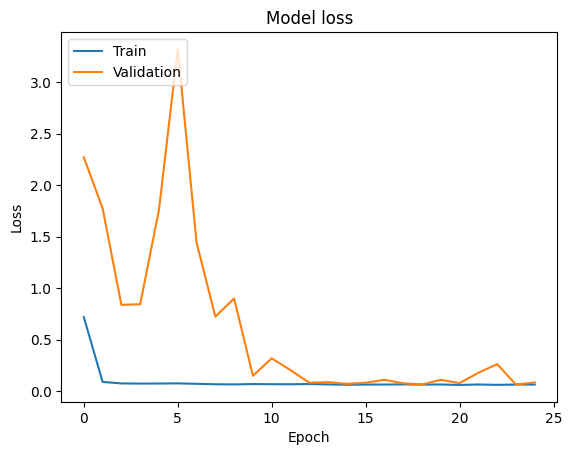

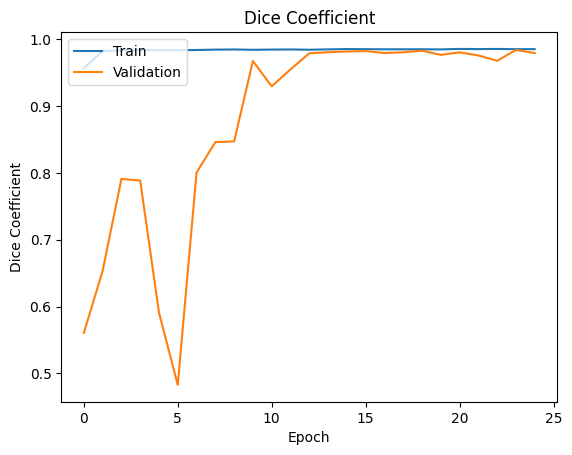

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation dice coefficient values
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
y_pred = model.predict(test_images)
y_pred.shape

10/10 [==============================] - 2s 129ms/step


(292, 224, 224, 3)

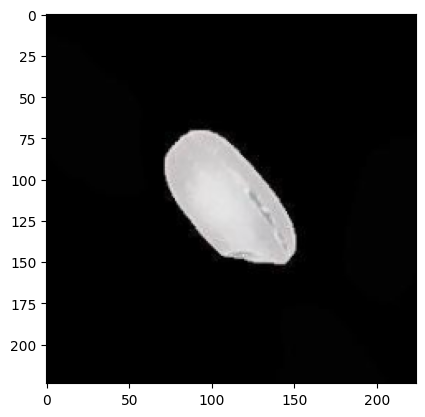

In [11]:
plt.imshow(test_images[0], cmap='gray')
plt.show()

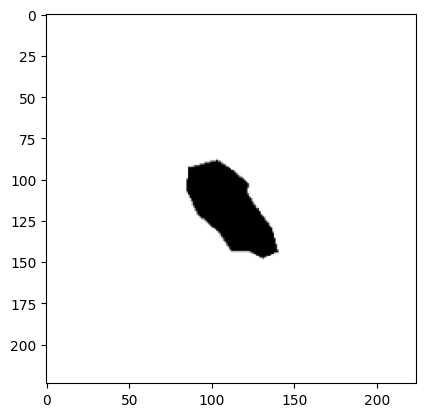

In [12]:
plt.imshow(test_masks[0], cmap='gray')
plt.show()

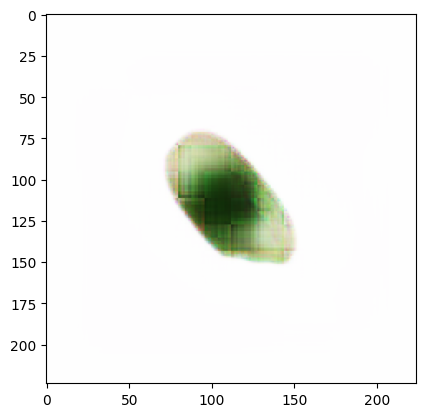

In [13]:
plt.imshow(y_pred[0], cmap='gray')
plt.show()

In [102]:
y_pred.shape

(292, 224, 224, 3)

In [109]:
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=1)
axs[2].imshow(mean_pred_mask, cmap='gray', norm=norm)

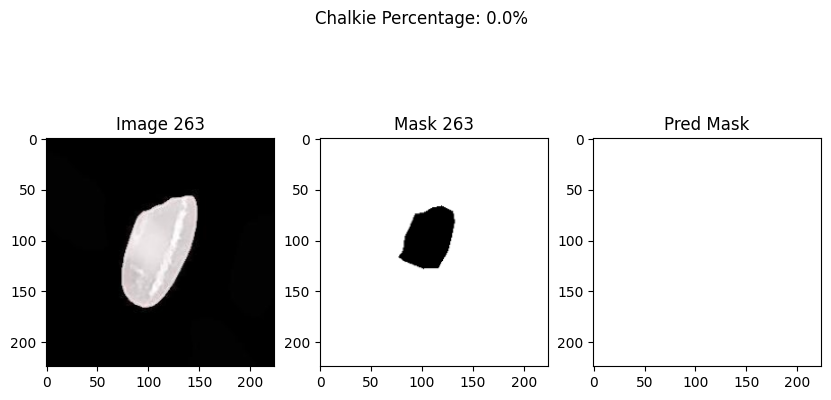

In [161]:
import matplotlib.pyplot as plt

# Assuming train_image[32] and train_masks[32] are your images
i = np.random.randint(0, len(test_images))
image = test_images[i]
mask = test_masks[i]
pred_mask = y_pred[i]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the image on the left subplot
axs[0].imshow(image, cmap='gray')
axs[0].set_title(f'Image {i}')

# Plot the mask on the right subplot
axs[1].imshow(mask, cmap='gray')
axs[1].set_title(f'Mask {i}')

# Plot the mask on the right subplot
mean_pred_mask = np.mean(pred_mask, axis=2)
mean_pred_mask = np.where(mean_pred_mask>.5, 1, 0)

norm = Normalize(vmin=0, vmax=1)
axs[2].imshow(mean_pred_mask, cmap='gray', norm=norm)
axs[2].set_title('Pred Mask')

y_true_percentage = np.where(image>.5, 1.0, 0.0)[:, :, 0]
y_pred_percentage = mean_pred_mask

intersection = K.sum(y_true_percentage * y_pred_percentage)
chalkie_percentage = 1-(intersection.numpy()/K.sum(y_true_percentage).numpy())

# Display the figure
fig.suptitle(f'Chalkie Percentage: {round(chalkie_percentage * 100, 2)}%')
plt.show()

In [108]:
mean_pred_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [112]:
test_images[0].shape

(224, 224, 3)

In [114]:
test_image_single = tf.expand_dims(test_images[0], axis=0)

In [115]:
test_image_single.shape

TensorShape([1, 224, 224, 3])

In [113]:
print(model.input_shape)


(None, 224, 224, 3)


In [117]:
y_pred_single = model.predict(test_image_single)

1/1 [==============================] - 0s 22ms/step


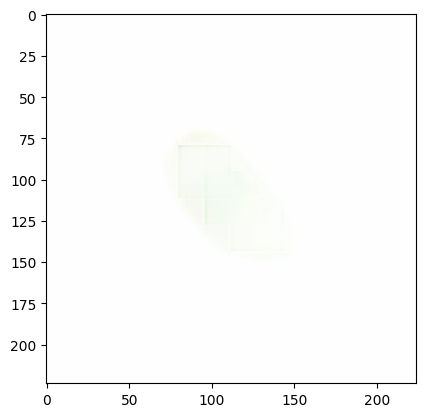

In [128]:
plt.imshow(y_pred_single[0], cmap='gray')
plt.show()

In [133]:
y_pred = model.predict(train_images)
y_pred.shape

37/37 [==============================] - 1s 32ms/step


(1167, 224, 224, 3)

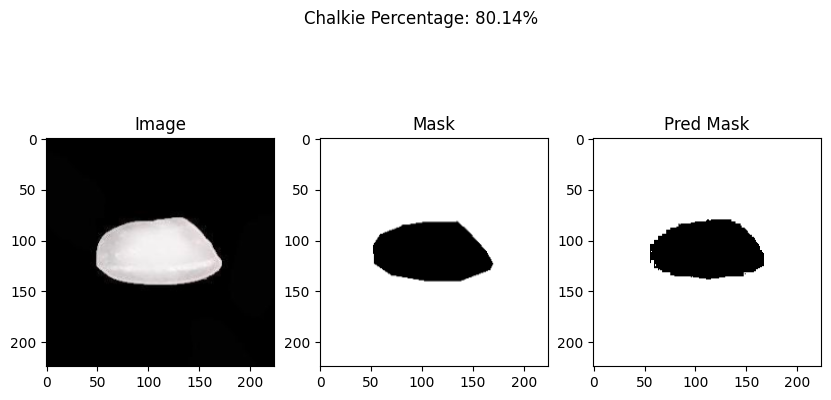

In [134]:
import matplotlib.pyplot as plt

# Assuming train_image[32] and train_masks[32] are your images
i = np.random.randint(0, len(train_images))
image = train_images[i]
mask = train_masks[i]
pred_mask = y_pred[i]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the image on the left subplot
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Image')

# Plot the mask on the right subplot
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')

# Plot the mask on the right subplot
mean_pred_mask = np.mean(pred_mask, axis=2)
mean_pred_mask = np.where(mean_pred_mask>.5, 1, 0)

axs[2].imshow(mean_pred_mask, cmap='gray')
axs[2].set_title('Pred Mask')

y_true_percentage = np.where(image>.5, 1.0, 0.0)[:, :, 0]
y_pred_percentage = mean_pred_mask

intersection = K.sum(y_true_percentage * y_pred_percentage)
chalkie_percentage = 1-(intersection.numpy()/K.sum(y_true_percentage).numpy())

# Display the figure
fig.suptitle(f'Chalkie Percentage: {round(chalkie_percentage * 100, 2)}%')
plt.show()

In [159]:
y_pred = model.predict(test_images)
y_pred.shape

10/10 [==============================] - 2s 131ms/step


(292, 224, 224, 3)

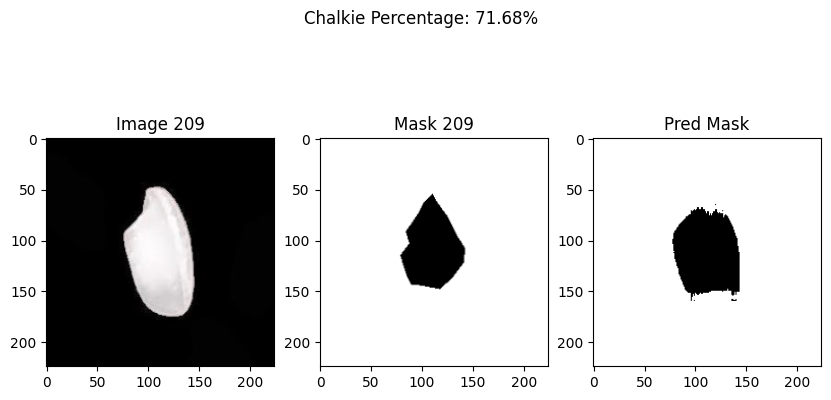

In [14]:
# Assuming train_image[32] and train_masks[32] are your images
i = np.random.randint(0, len(test_images))
image = test_images[i]
mask = test_masks[i]
pred_mask = y_pred[i]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the image on the left subplot
axs[0].imshow(image, cmap='gray')
axs[0].set_title(f'Image {i}')

# Plot the mask on the right subplot
axs[1].imshow(mask, cmap='gray')
axs[1].set_title(f'Mask {i}')

# Plot the predicted mask on the right subplot
mean_pred_mask = np.mean(pred_mask, axis=2)
mean_pred_mask = np.where(mean_pred_mask > 0.5, 1, 0)

axs[2].imshow(mean_pred_mask, cmap='gray')
axs[2].set_title('Pred Mask')

y_true_percentage = np.where(image > 0.5, 1.0, 0.0)[:, :, 0]
y_pred_percentage = mean_pred_mask

intersection = np.sum(y_true_percentage * y_pred_percentage)
chalkie_percentage = 1 - (intersection / np.sum(y_true_percentage))

# Display the figure
fig.suptitle(f'Chalkie Percentage: {round(chalkie_percentage * 100, 2)}%')
plt.show()


In [48]:
path = 'dataset/dataset_'

image_p = os.listdir(path)
image_path = [i for i in image_p]

train_grain = []
test_grain = []

for i, v in tqdm(enumerate(image_path)):
    # jalan = f'dataset/dataset_/{v}/img.png'
    # img = cv2.imread(jalan)
    # img = cv2.resize(img, (224, 224))

    jalan_label = f'dataset/dataset_/{v}/masking_grain.png'
    img_label = cv2.imread(jalan_label, 0)
    img_label = cv2.resize(img_label, (224, 224))
    img_label = np.stack([img_label] * 3, axis=-1)

    if i > 1166:  # Assuming 1167 is your threshold for the test set
        test_grain.append(img_label)
    else:
        train_grain.append(img_label)

# Convert to NumPy arrays
train_grain = np.array(train_grain).astype('float32') / 255
test_grain = np.array(test_grain).astype('float32') / 255

print(f'''
Train grain Shape: {train_grain.shape}
Test grain Shape: {test_grain.shape}
''')

1459it [00:08, 175.42it/s]



Train grain Shape: (1167, 224, 224, 3)
Test grain Shape: (292, 224, 224, 3)



In [167]:
import numpy as np

# Simulasi mask keseluruhan dan mask kapur
mask_keseluruhan = inverted_mask_1.astype(int)  # Ensure the data type is integer
mask_kapur = test_masks[260].astype(int)  # Ensure the data type is integer

# Menghitung jumlah piksel ter-mask untuk mask kapur
total_piksel_kapur = np.sum(mask_kapur == 1)

# Menghitung jumlah piksel ter-mask untuk mask keseluruhan butir beras
total_piksel_keseluruhan = np.sum(mask_keseluruhan == 1)

# Menghitung persentase masking kapur
persentase_kapur = (total_piksel_kapur / total_piksel_keseluruhan) * 100

print(f'Persentase Masking Kapur: {persentase_kapur:.2f}%')


Persentase Masking Kapur: 107.26%


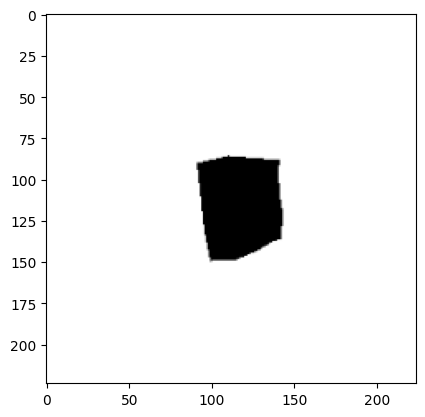

In [71]:
plt.imshow(test_masks[260], cmap='gray')
plt.show()

In [69]:
import numpy as np

# Assuming 'mask' is your image mask
mask = test_grain[260]

# Method 1: Subtract the mask from 1
inverted_mask_1 = 1 - mask

# Method 2: Bitwise NOT operation

# If the mask is a floating-point image, you might want to round the values
# to convert any potential floating-point values to either 0 or 1
inverted_mask_1 = np.round(inverted_mask_1)
# Now, 'inverted_mask_1' and 'inverted_mask_2' contain the inverted pixel values


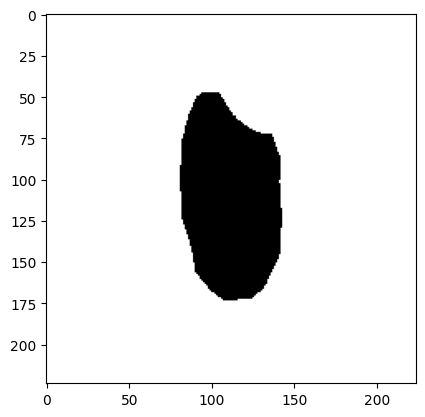

In [70]:
plt.imshow(inverted_mask_1, cmap='gray')
plt.show()

In [72]:
import numpy as np

# Simulate overall rice mask and chalk mask
overall_rice_mask = np.array(inverted_mask_1)

chalk_mask = np.array(test_masks[260])

# Count the number of chalk pixels
chalk_pixels = np.sum(chalk_mask == 1)

# Count the total number of pixels in the overall rice mask
total_pixels = np.sum(overall_rice_mask == 1)

# Calculate the percentage of chalk pixels
percentage_chalk = (chalk_pixels / total_pixels) * 100

print(f'Percentage of Chalk in Overall Rice: {percentage_chalk:.2f}%')


Percentage of Chalk in Overall Rice: 107.26%


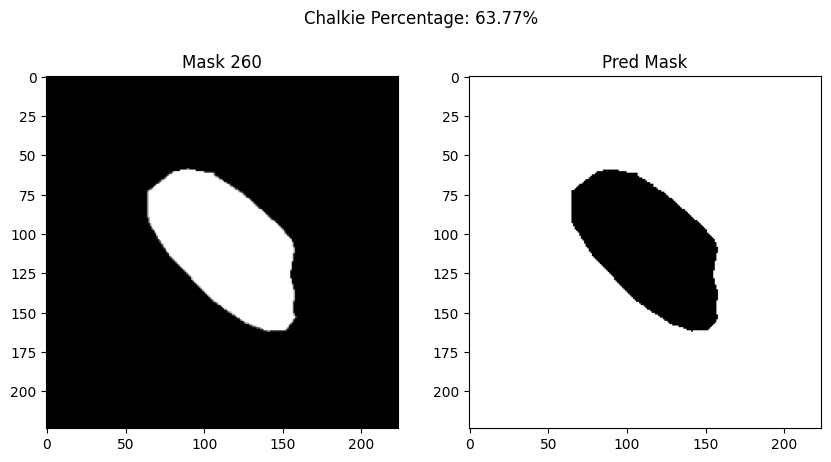

In [29]:
# Assuming train_image[32] and train_masks[32] are your images
i = np.random.randint(0, len(test_images))
mask = test_grain[i]
pred_mask = test_masks[i]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mask on the right subplot
axs[0].imshow(mask, cmap='gray')
axs[0].set_title(f'Mask {i}')

# Plot the predicted mask on the right subplot
mean_pred_mask = np.mean(pred_mask, axis=2)
mean_pred_mask = np.where(mean_pred_mask > 0.5, 1, 0)

axs[1].imshow(mean_pred_mask, cmap='gray')
axs[1].set_title('Pred Mask')

y_true_percentage = np.where(image > 0.5, 1.0, 0.0)[:, :, 0]
y_pred_percentage = mean_pred_mask

intersection = np.sum(y_true_percentage * y_pred_percentage)
chalkie_percentage = 1 - (intersection / np.sum(y_true_percentage))

# Display the figure
fig.suptitle(f'Chalkie Percentage: {round(chalkie_percentage * 100, 2)}%')
plt.show()


In [31]:
i

275

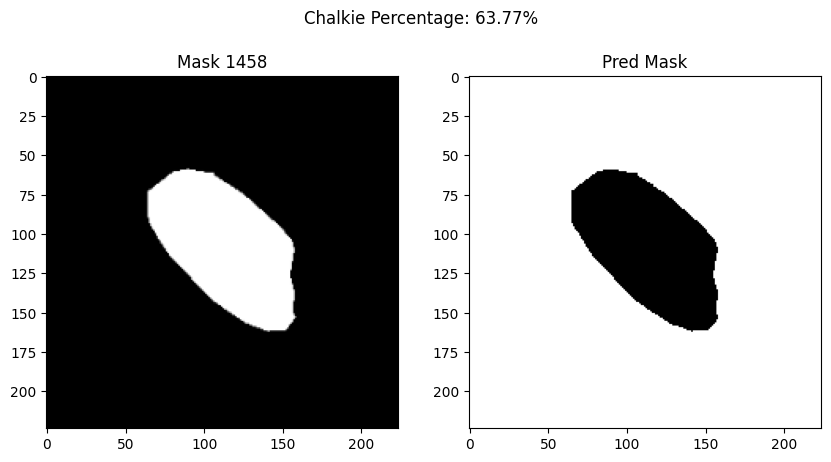

In [49]:
# Assuming train_image[32] and train_masks[32] are your images
mask = test_grain[275]
pred_mask = test_masks[275]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mask on the right subplot
axs[0].imshow(mask, cmap='gray')
axs[0].set_title(f'Mask {i}')

# Plot the predicted mask on the right subplot
mean_pred_mask = np.mean(pred_mask, axis=2)
mean_pred_mask = np.where(mean_pred_mask > 0.5, 1, 0)

axs[1].imshow(mean_pred_mask, cmap='gray')
axs[1].set_title('Pred Mask')

y_true_percentage = np.where(image > 0.5, 1.0, 0.0)[:, :, 0]
y_pred_percentage = mean_pred_mask

intersection = np.sum(y_true_percentage * y_pred_percentage)
chalkie_percentage = 1 - (intersection / np.sum(y_true_percentage))

# Display the figure
fig.suptitle(f'Chalkie Percentage: {round(chalkie_percentage * 100, 2)}%')
plt.show()

ValueError: operands could not be broadcast together with shapes (224,224,3) (224,224) 

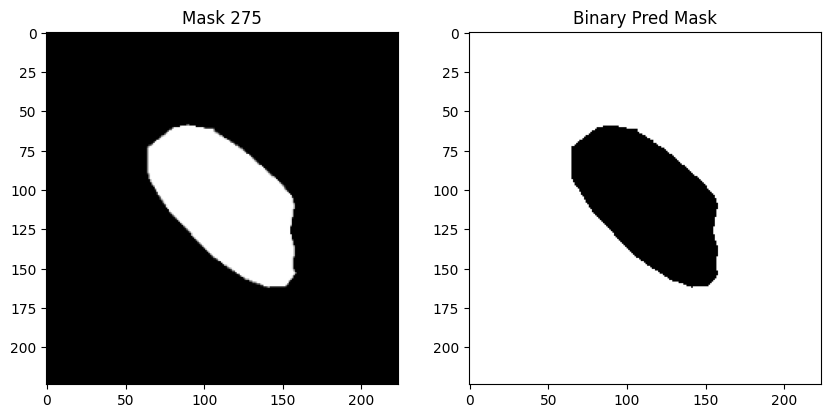

In [44]:
# Assuming train_image[32] and train_masks[32] are your images
mask = test_grain[275]
pred_mask = test_masks[275]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mask on the left subplot
axs[0].imshow(mask, cmap='gray')
axs[0].set_title(f'Mask {275}')

# Plot the predicted mask on the right subplot
mean_pred_mask = np.mean(pred_mask, axis=2)

# Assuming 0.5 as the threshold for binary prediction
threshold = 0.5
binary_pred_mask = np.where(mean_pred_mask > threshold, 1, 0)

axs[1].imshow(binary_pred_mask, cmap='gray')
axs[1].set_title('Binary Pred Mask')

# Calculate the Chalkie Percentage
y_true_percentage = np.where(mask > 0.5, 1.0, 0.0)  # Assuming mask values are in the range [0, 1]
y_pred_percentage = np.where(mean_pred_mask > threshold, 1, 0)

intersection = np.sum(y_true_percentage * y_pred_percentage)
chalkie_percentage = 1 - (intersection / np.sum(y_true_percentage))

# Display the figure
fig.suptitle(f'Chalkie Percentage: {round(chalkie_percentage * 100, 2)}%')
plt.show()
